# Deep Learning model의 class weight 조정

## DNN 이용, Class Weight 조정, OverSampling

- Data 는 이전 실습 문제와 동일한 [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) - Kaggle

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import  accuracy_score, precision_score, recall_score, \
                            roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
mpl.rcParams['figure.figsize'] = (12, 10)

### Kaggle Credit Card Fraud dataset 다운로드

In [2]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 클래스 레이블 불균형 조사

In [3]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [4]:
neg, pos = df['Class'].value_counts().values.tolist()
total = neg + pos
print(f'Total 건수: {total}\nPositive 건수/비율: {pos} ({pos/total*100:.2f}%)')

Total 건수: 284807
Positive 건수/비율: 492 (0.17%)


## Data 전처리

- 2 일 동안의 data가 00:00:00 부터 발생했으므로 Time을 일중 시간으로 변경 : time / 3600 초 % 24 시간  
- Amount column 은 편차가 크므로 log-scale 로 변환

In [5]:
cleaned_df = df.copy()

# Time 을 일중 시간으로 변환
cleaned_df.loc[:, "Time"] = cleaned_df.loc[:, "Time"].apply(lambda x : x / 3600 % 24)

# Amount column 은 편차가 크므로 log-scale 로 변환
eps=0.001
cleaned_df['Amount'] = np.log(cleaned_df.pop('Amount') + eps)

cleaned_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


<Axes: ylabel='Frequency'>

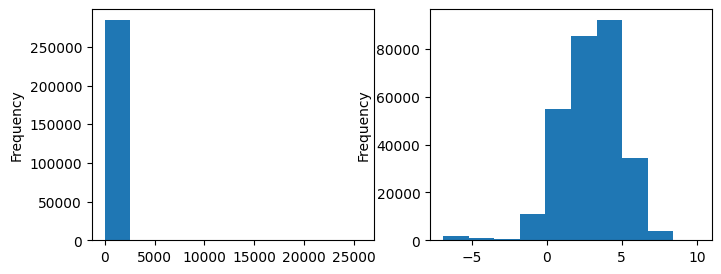

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
df['Amount'].plot(kind='hist', ax=ax1)
cleaned_df['Amount'].plot(kind='hist', ax=ax2)

In [7]:
labels = np.array(cleaned_df.pop('Class'))
labels

array([0, 0, 0, ..., 0, 0, 0])

In [8]:
features = cleaned_df.values
features.shape

(284807, 30)

<Axes: ylabel='count'>

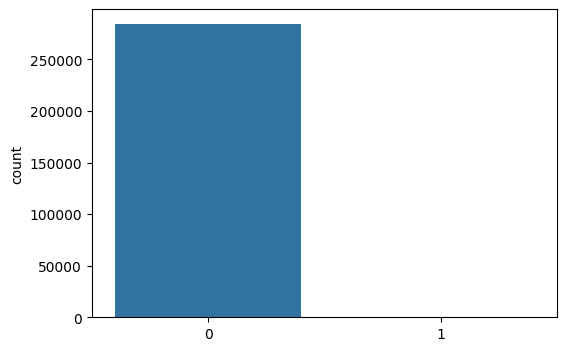

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x=labels)

### Dataset 을 Training 과 Test set 으로 분리

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                test_size=0.5, random_state=0, stratify=labels)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142403, 30), (142404, 30), (142403,), (142404,))

In [11]:
print("전체 data의 positive 건수 : ", Counter(labels))
print("Train set 의 positive 건수 : ", Counter(y_train))
print("Test set 의 positive 건수 : ", Counter(y_test))

전체 data의 positive 건수 :  Counter({0: 284315, 1: 492})
Train set 의 positive 건수 :  Counter({0: 142157, 1: 246})
Test set 의 positive 건수 :  Counter({0: 142158, 1: 246})


## Feature Scaling

In [12]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

### Metrics 정의
- model train 중 측정할 metric  정의

In [13]:
METRICS = tf.keras.metrics.AUC(name='auc')

## Simple NN model 정의 - 이진 분류 모델

In [14]:
def make_model():
    model = tf.keras.Sequential([
      Dense(32, activation='relu', input_shape=(X_train.shape[-1],)),
      Dropout(0.2),
      Dense(16, activation='relu'),
      Dropout(0.2),
      Dense(1, activation='sigmoid'),
      ])

    model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
      loss = 'binary_crossentropy', metrics=[METRICS, 'accuracy'])

    return model

### Baseline model build

In [15]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=10,        # no of epochs of no improvement
    mode='max',        #val_auc 가 10 번 연속 증가 안하면 stop
    restore_best_weights=True)      # epoch 의 best weight 저장

In [16]:
base_model = make_model()
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                992       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train the model

In [17]:
baseline_history = base_model.fit(X_train, y_train, batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             callbacks=[early_stopping],
                             validation_data=(X_test, y_test))

Epoch 1/100
70/70 [==============================] - 4s 10ms/step - loss: 0.0607 - auc: 0.7739 - accuracy: 0.9874 - val_loss: 0.0043 - val_auc: 0.9082 - val_accuracy: 0.9993
Epoch 2/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0048 - auc: 0.9250 - accuracy: 0.9992 - val_loss: 0.0039 - val_auc: 0.9283 - val_accuracy: 0.9993
Epoch 3/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0042 - auc: 0.9352 - accuracy: 0.9992 - val_loss: 0.0036 - val_auc: 0.9343 - val_accuracy: 0.9994
Epoch 4/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0039 - auc: 0.9518 - accuracy: 0.9991 - val_loss: 0.0035 - val_auc: 0.9345 - val_accuracy: 0.9994
Epoch 5/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0035 - auc: 0.9621 - accuracy: 0.9992 - val_loss: 0.0036 - val_auc: 0.9365 - val_accuracy: 0.9994
Epoch 6/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0033 - auc: 0.9603 - accuracy: 0.9992 - val_loss: 0.0036 - 

In [18]:
# baseline_history 객체의 history 속성에서 'val_accuracy' 키에 해당하는 값을 가져옵니다.
# 따라서, 이 코드는 모델 학습 마지막 에포크에서 검증 데이터에 대한 정확도를 출력합니다.
val_accuracy_last = baseline_history.history['val_accuracy'][-1]
val_accuracy_last

0.99937504529953

## Evaluate Metric

- confusion matrix 를 이용하여 metrics 요약

In [19]:
predictions_baseline  = base_model.predict(X_test, verbose=0)
predictions_baseline.shape

(142404, 1)

In [20]:
def plot_cm(y_test, y_pred_prob, threshold):

    y_pred = y_pred_prob > threshold

    cm = confusion_matrix(y_test, y_pred)

    print("f1 score:", f1_score(y_test, y_pred))
    print("Accuracy", accuracy_score(y_test, y_pred))
    print("Precision", precision_score(y_test, y_pred))
    print("Recall", recall_score(y_test, y_pred))

    plt.figure(figsize=(5,5))

    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix (threshold>{:.2f}) '.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

### Test dataset 으로 모델을 평가 하고, confusion matrix 를 그린다

f1 score: 0.8043010752688171
Accuracy 0.9993609730063763
Precision 0.8538812785388128
Recall 0.7601626016260162


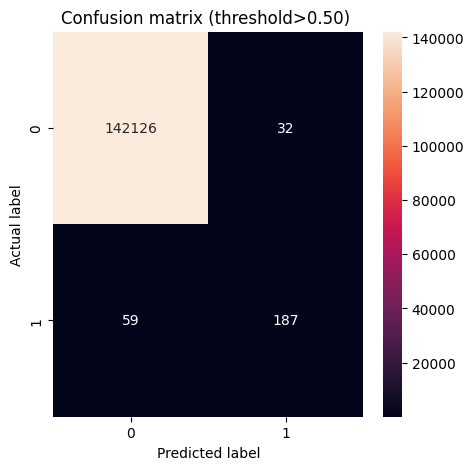

In [21]:
plot_cm(y_test, predictions_baseline, threshold=0.5)

## Class Weight 조정

사용할 positive 샘플이 많지 않기 때문에 가용한 적은 수의 sample 에 classifier 가 더 비중을 두도록 할 수 있다.  이는 모델이 과소 표현된 클래스의 샘플에 `더 많은주의를 기울이도록` 지시하는 데 유용.

step1 - 레이블 및 관련 가중치로 dictionary 정의
```
class_weight ={0: 0.5008652375006595, 1: 289.43800813008136}
```                
step2 - dictionary를 매개 변수로 공급:  
```
    model.fit(X_train, Y_train, nb_epoch=5, batch_size=32, class_weight=class_weight)
```

- loss function 계산 시 class_weight 에 지정된 대로 가중 평균

In [22]:
neg, pos, total

(284315, 492, 284807)

각 클래스의 샘플 수에 반비례하는 가중치를 계산하여, 모델 학습 시 소수 클래스의 중요도를 증가시키고 다수 클래스의 중요도를 감소시킵니다. 이 방법은 모델이 소수 클래스를 더 잘 학습하도록 돕습니다.

In [23]:
# 0 클래스(다수 클래스)와 1 클래스(소수 클래스)의 샘플 수를 바탕으로 각 클래스의 가중치를 계산
# neg는 0 클래스의 샘플 수, pos는 1 클래스의 샘플 수, total은 전체 샘플 수
weight_for_0 = (1 / neg) * (total) / 2
weight_for_1 = (1 / pos) * (total) / 2

# class_weight 딕셔너리에 계산된 가중치를 할당
class_weight = {0: weight_for_0, 1: weight_for_1}

# 각 클래스에 대한 가중치 출력
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [24]:
class_weight

{0: 0.5008652375006595, 1: 289.43800813008136}

In [25]:
weighted_model = make_model()

weighted_history = weighted_model.fit(X_train, y_train,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    callbacks = [early_stopping],
                                    validation_data=(X_test, y_test),
                                    class_weight=class_weight)

Epoch 1/100
70/70 [==============================] - 2s 9ms/step - loss: 0.3326 - auc: 0.9088 - accuracy: 0.8704 - val_loss: 0.1638 - val_auc: 0.9764 - val_accuracy: 0.9713
Epoch 2/100
70/70 [==============================] - 0s 6ms/step - loss: 0.2116 - auc: 0.9671 - accuracy: 0.9620 - val_loss: 0.1188 - val_auc: 0.9756 - val_accuracy: 0.9785
Epoch 3/100
70/70 [==============================] - 0s 6ms/step - loss: 0.1704 - auc: 0.9768 - accuracy: 0.9702 - val_loss: 0.1283 - val_auc: 0.9747 - val_accuracy: 0.9785
Epoch 4/100
70/70 [==============================] - 0s 6ms/step - loss: 0.1491 - auc: 0.9852 - accuracy: 0.9735 - val_loss: 0.1016 - val_auc: 0.9790 - val_accuracy: 0.9751
Epoch 5/100
70/70 [==============================] - 0s 6ms/step - loss: 0.1392 - auc: 0.9866 - accuracy: 0.9721 - val_loss: 0.1220 - val_auc: 0.9771 - val_accuracy: 0.9669
Epoch 6/100
70/70 [==============================] - 0s 6ms/step - loss: 0.1209 - auc: 0.9908 - accuracy: 0.9752 - val_loss: 0.1056 - v

In [26]:
predictions_weighted = weighted_model.predict(X_test)

4451/4451 [==============================] - 6s 1ms/step


loss :  0.10160359740257263
auc :  0.9789513945579529
accuracy :  0.9751481413841248

f1 score: 0.11147376349485313
Accuracy 0.9751481699952248
Precision 0.0594059405940594
Recall 0.9024390243902439


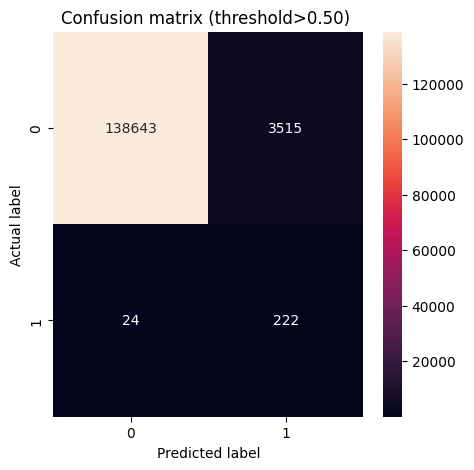

In [27]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(y_test, predictions_weighted, threshold=0.5)

## Plot the ROC

In [28]:
def plot_roc(name, labels, predictions, **kwargs):
    # ROC 곡선을 그리기 위한 FPR(위양성률)과 TPR(진양성률)을 계산합니다.
    fp, tp, _ = roc_curve(labels, predictions)
    # AUC(Area Under the Curve) 값을 계산합니다.
    auc = roc_auc_score(labels, predictions)  # y_test 대신 labels를 사용해야 합니다

    # ROC 곡선을 그립니다. FPR을 x축, TPR을 y축으로 설정합니다.
    # label은 모델 이름과 AUC 값을 포함하며, linewidth는 선의 두께를 설정합니다.
    plt.plot(100*fp, 100*tp, label=f"auc of {name}={auc:.5f}", linewidth=2, **kwargs)
    plt.xlabel('FP [%]')
    plt.ylabel('TP [%]')
    plt.xlim([-0.5, 20])  # x축의 범위를 설정합니다.
    plt.ylim([80, 100.5])  # y축의 범위를 설정합니다.
    plt.grid(True)
    # 현재 그래프의 축 객체를 가져옵니다.
    ax = plt.gca()
    ax.set_aspect('equal')  # 축의 종횡비를 동일하게 설정합니다.
    fig = plt.gcf()     # 현재 그래프의 Figure 객체를 가져옵니다.
    fig.set_size_inches(8, 6)   # Figure 객체의 크기를 가로 8인치, 세로 6인치로 설정
    plt.legend(loc='lower right')   # 범례를 추가합니다.

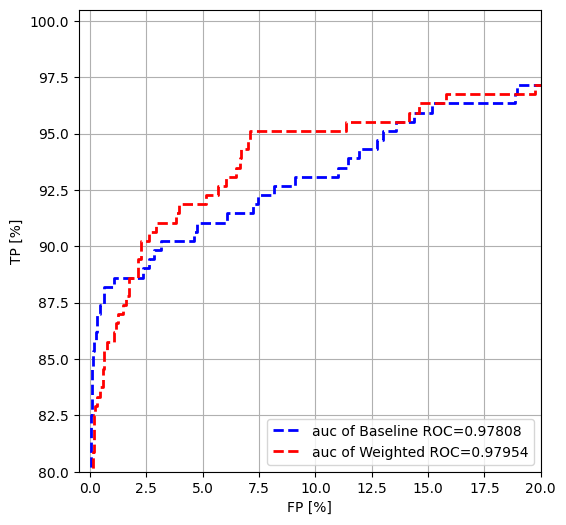

In [29]:
plot_roc("Baseline ROC", y_test, predictions_baseline, color='blue', linestyle='--')
plot_roc("Weighted ROC", y_test, predictions_weighted, color='red', linestyle='--')

plt.legend(loc='lower right')

## Next Step => Over+Under-sampling model과 weight 조절 DNN model 비교